<a href="https://colab.research.google.com/github/Franco-Urrutia-G/EIE401-1s-2024/blob/main/Actividades/Actividad%206/Actividad_6_Opcional_UrrutiaFranco_18916762-8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
TRAIN_PATH = '/content/PinkPanther30.wav'

In [ ]:
sample_rate, audio = wavfile.read(TRAIN_PATH)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 22050Hz
Audio duration: 30.0s


In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

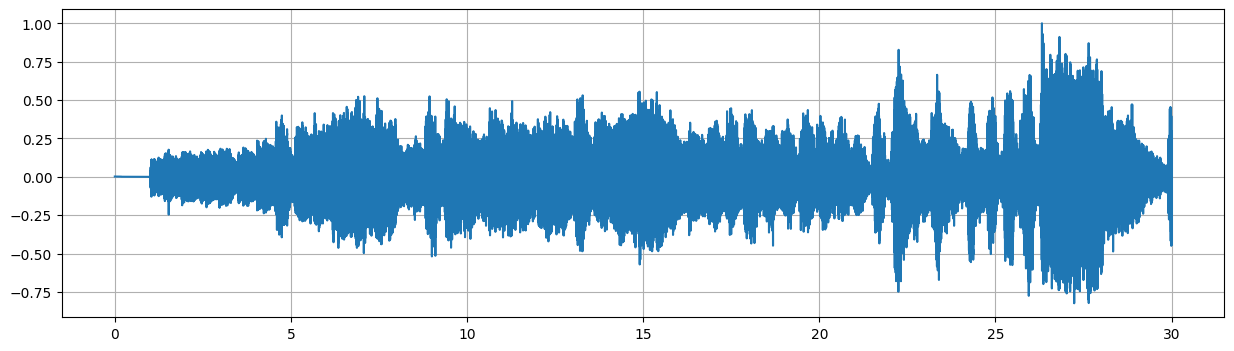

In [ ]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms

    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]

    return frames

In [ ]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (1999, 2048)


In [ ]:
print("First frame:")
audio_framed[1]

First frame:


array([0.00181922, 0.00193292, 0.00181922, ..., 0.00181922, 0.00193292,
       0.00204662])

In [ ]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([-0.03058556, -0.04820921, -0.08686754, ...,  0.03297328,
        0.01284821, -0.01046049])

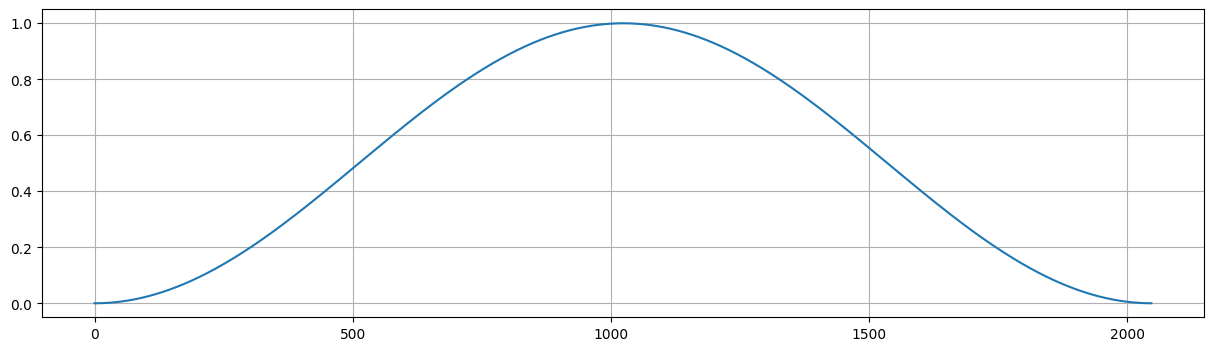

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

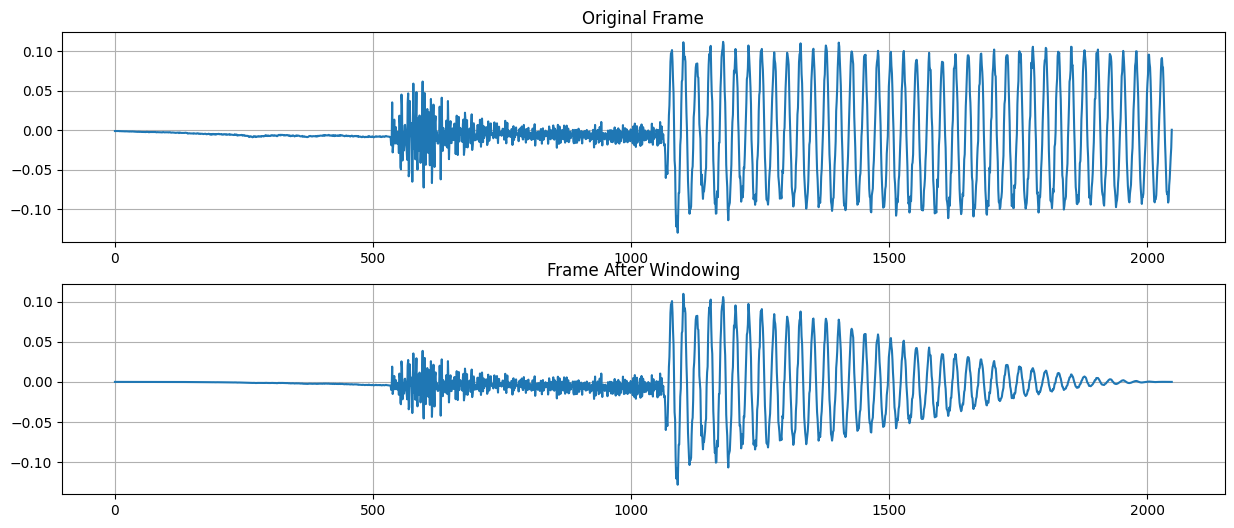

In [ ]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [ ]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(1999, 1025)


In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 11025.0


In [ ]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [ ]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)

    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)

    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [ ]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3176.318435512582


array([  0,   9,  21,  37,  58,  84, 118, 162, 220, 293, 389, 512])

In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))

    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])

    return filters

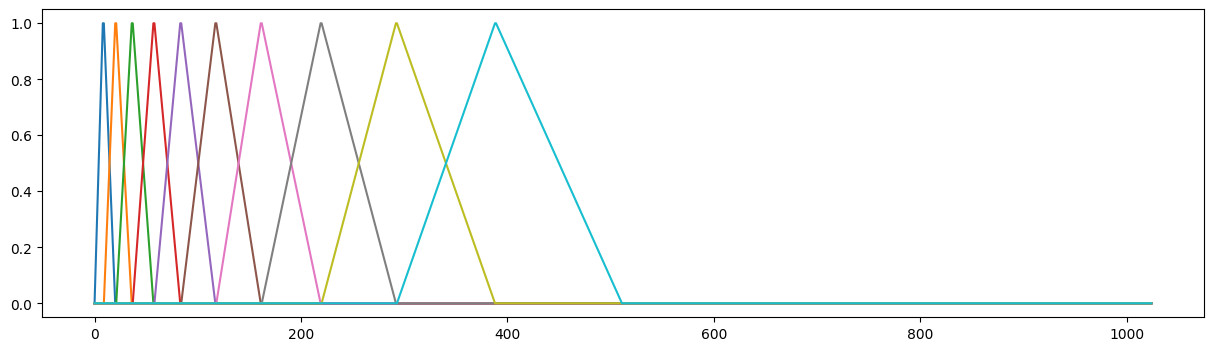

In [ ]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

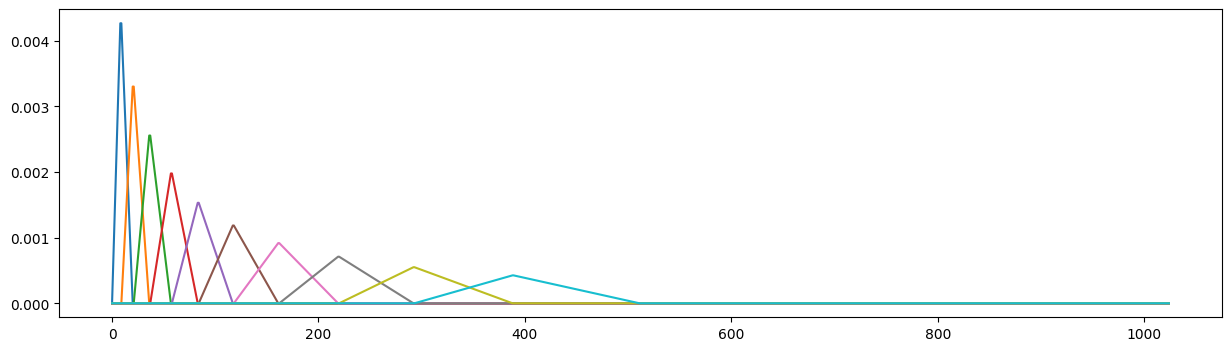

In [ ]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

<ipython-input-31-535512a2e3ed>:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


(10, 1999)

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)

    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)

    return basis

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 1999)

In [ ]:
cepstral_coefficents[:, 0]

array([-1.87285114e+02,  1.89451235e+01,  1.82302016e+01,  8.32103325e+00,
        8.89752422e+00,  6.46499137e+00,  1.97142020e+00,  3.37432470e+00,
        8.47803505e-01,  7.38302177e-01,  2.72462644e-13, -7.38302177e-01,
       -8.47803505e-01, -3.37432470e+00, -1.97142020e+00, -6.46499137e+00,
       -8.89752422e+00, -8.32103325e+00, -1.82302016e+01, -1.89451235e+01,
        2.64861149e+02, -1.89451235e+01, -1.82302016e+01, -8.32103325e+00,
       -8.89752422e+00, -6.46499137e+00, -1.97142020e+00, -3.37432470e+00,
       -8.47803505e-01, -7.38302177e-01, -5.43322125e-14,  7.38302177e-01,
        8.47803505e-01,  3.37432470e+00,  1.97142020e+00,  6.46499137e+00,
        8.89752422e+00,  8.32103325e+00,  1.82302016e+01,  1.89451235e+01])

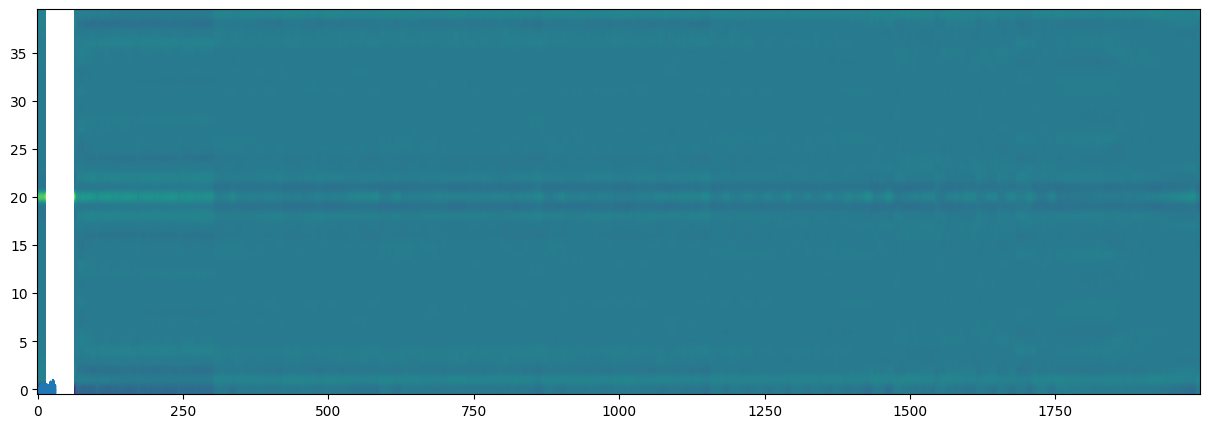

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');